# Student Performance from Game Play Using TensorFlow Decision Forests

---
## Introduction



The aim of this project is to develop a predictive model for real-time assessment of student performance during game-based learning. The model will be built on one of the most extensive open datasets of game logs available.

This undertaking will contribute to the evolution of knowledge-tracing methodologies for game-based learning. The outcome will aid educational game developers in crafting more effective and immersive learning experiences for students.


## Context

Game-based learning is designed to make education an engaging and interactive process. It places educational content within a game framework, turning learning into a dynamic and enjoyable experience. Despite its increasing usage in various educational contexts, open datasets that can be applied to refine game-based learning using data science and learning analytic principles are still limited.

Currently, many game-based learning platforms don't fully harness the power of knowledge tracing to assist individual learners. While knowledge tracing methodologies have been researched and implemented in online learning environments and intelligent tutoring systems, they are not as widely used in educational games.

Our project collaborator, Field Day Lab, is a public research lab at the Wisconsin Center for Educational Research. They develop games for a wide range of subjects and age groups, bringing contemporary research to the public. They utilize game data to gain insights into learning processes. With their commitment to accessibility, all games developed by Field Day Lab are freely available to everyone. They also work in partnership with nonprofit organizations such as The Learning Agency Lab, which focuses on creating science of learning-based tools and programs for social welfare.

Successful completion of this project will empower game developers to enhance educational games. It will also provide educators using these games with dashboards and analytical tools, potentially leading to broader support for game-based learning platforms.

Our goal is to train models for each question to predict the label "correct" for a input user session using a supervised machine learning algorithm.


In [3]:
# This function will save memory to prevent errors 
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Import the Required Libraries

In [4]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-06-22 20:37:07.385189: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 20:37:07.519867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-22 20:37:07.520510: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 20:37:08.415650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 

In [5]:
print("TensorFlow Decision Forests v" + tfdf.__version__)
print("TensorFlow Addons v" + tfa.__version__)
print("TensorFlow v" + tf.__version__)

TensorFlow Decision Forests v1.3.0
TensorFlow Addons v0.20.0
TensorFlow v2.12.0


# Load the Dataset

Given the considerable size of the dataset, encountering memory errors when attempting to load the dataset from the CSV file is a plausible scenario. As a response, the goal here is to optimize the memory utilized by Pandas when loading and managing the dataset.

Typically, Pandas auto-detects the datatypes of different columns upon loading a dataset. This process involves assigning int64 for numerical columns, float64 for floating-point columns, object dtype for string columns, and so on, irrespective of the maximum value held in these columns.

There exists an opportunity to minimize the memory footprint of these columns by downcasting numerical columns to smaller types (like int8, int32, float32, etc.), as long as the highest values in these columns don't require larger storage types (for instance, int64, float64, etc.).

In the same vein, Pandas automatically classifies string columns as object datatype. If these string columns store categorical data, their memory consumption can be reduced by designating their datatype as 'category'.

There are multiple columns in the current dataset that are candidates for downcasting to smaller types.

To aid this process, Pandas will be provided with a dictionary of datatypes for different columns during the loading of the dataset.

In [6]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

dataset_df = pd.read_csv('train.csv', dtype=dtypes)
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (26296946, 20)


In [4]:
# Display the first 5 examples
dataset_df.head(5)

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


`session_id` uniquely identifies a user session.

# Feature Explanation
**Most of these features seem unlikely to impact a prediction:**


1. **session_id:** The ID of a session merely serves as a unique identifier and doesn't provide any substantive information about a gamer's performance.

2. **index:** Similarly, the index of an event for a session is an ordering detail that does not correlate with a player's skill level.

3. **elapsed_time:** This feature provides temporal context of the TOTAL time in a session but not on the exact question. However we can extrapolate time elapsed for one question with a little engineering.

4. **event_name, name:** These are specific events or actions taken in the game, which can be quite diverse and may not necessarily reflect the player's overall performance.

5. **level:** While this might seem useful at first, it may not necessarily correlate with performance because a lower level does not mean a player is less skilled - they could be new to the game or replaying earlier levels.

6. **page, room_coor_x, room_coor_y, screen_coor_x, screen_coor_y, hover_duration:** These features are specific to certain types of events and hence provide limited information. A single click or hover event does not adequately represent a gamer's overall performance.

7. **text:** The text that a player sees during an event is not a direct indicator of a player's ability or skill level.

8. **fqid, room_fqid, text_fqid:** These are identifiers for the event and its context, but again, do not offer insights into the player's performance.

9. **fullscreen, hq, music:** These options are player preferences and don't necessarily correlate with performance. A player can perform well irrespective of whether they play in fullscreen, high quality, or with music.

10. **level_group:** This provides broader categorization of the level but still suffers from the same limitations as the 'level' feature - it doesn't inherently reflect a player's performance. 



# Load the labels

The training dataset's labels are kept in the `train_labels.csv` file. This file contains information regarding the accuracy of each user's answers in specific sessions. You can load the labels data by executing the given code snippet. 

In the column named session_id, each entry is a fusion of the session identifier and the question number. For convenience, these will be separated into individual columns.

The objective here is to construct models for each question with the ability to predict the 'correct' label for any given user session.`

In [5]:
labels = pd.read_csv('train_labels.csv')

In [6]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [7]:
# Display the first 5 examples
labels.head(5)

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


# Bar charts for label spreads

<AxesSubplot: >

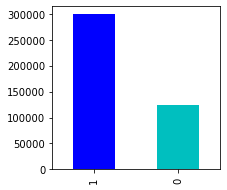

In [8]:
plt.figure(figsize=(3, 3))
plot_df = labels.correct.value_counts()
plot_df.plot(kind="bar", color=['b', 'c'])

Now, let us plot the values of the label column `correct` for each question. By doing this, we can see which questions would be easily predictable and which ones the model would have more trouble predicting.

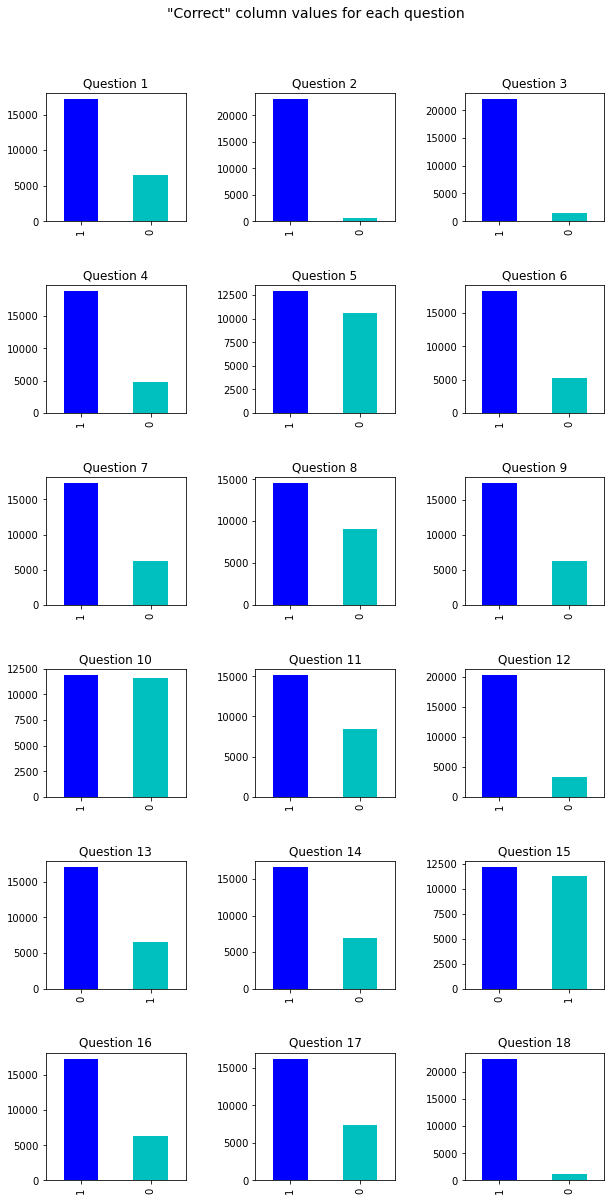

In [9]:
plt.figure(figsize=(10, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.suptitle("\"Correct\" column values for each question", fontsize=14, y=0.94)
for n in range(1,19):
    #print(n, str(n))
    ax = plt.subplot(6, 3, n)

    # filter df and plot ticker on the new subplot axis
    plot_df = labels.loc[labels.q == n]
    plot_df = plot_df.correct.value_counts()
    plot_df.plot(ax=ax, kind="bar", color=['b', 'c'])
    
    # chart formatting
    ax.set_title("Question " + str(n))
    ax.set_xlabel("")


# Feature Engineering dataset


The dataset delivers questions and data in the order of levels - level segments (denoted by the level_group column), specifically in groups of 0-4, 5-12, and 13-22. The task involves predicting the correctness of each segment's questions as they appear. To accomplish this, basic aggregate features will be constructed from the pertinent columns. Building more features could potentially enhance the prediction scores.

To begin with, two distinct lists will be established for the Categorical columns and Numerical columns. The columns fullscreen, hq, and music will be disregarded as they don't contribute valuable insights for this particular problem statement.

In [10]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

Each categorical column will undergo grouping by `session_id` and `level_group`. Following that, the quantity of **distinct elements** within each column for every group will be calculated and temporarily stored.

When handling numerical columns, the dataset will be grouped again by `session id` and `level_group`. Rather than tallying the count of unique elements, the `mean` and `standard deviation` for each numerical column within the group will be determined and temporarily stored.

Once these steps are completed, the temporary data frames generated for each column in the previous steps will be concatenated to create a newly feature-engineered dataset.

In [11]:
# Reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [12]:
dataset_df = feature_engineer(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

Full prepared dataset shape is (70686, 22)


# Basic exploration of the prepared dataset

Let us print out the first 5 entries using the following code:

In [13]:
# Display the first 5 examples
dataset_df.head(5)

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,3,30,7,17,8.579356e+04,1.945455,-1.0,7.701275,...,383.044861,2389.500000,49246.539458,1.230975,-1.000000,399.296038,129.292411,214.871000,104.082743,3227.370757
20090312431273200,13-22,10,3,49,12,35,1.040601e+06,17.402381,-1.0,-130.347168,...,379.301025,899.925903,126666.129584,2.358652,-1.000000,622.061374,230.370874,240.280218,99.067861,1305.088265
20090312431273200,5-12,10,3,39,11,24,3.572052e+05,8.054054,-1.0,14.306062,...,378.784912,969.333313,80175.676658,2.096919,-1.000000,357.227701,137.409476,203.268560,120.255453,1316.408315
20090312433251036,0-4,11,4,22,6,11,9.763342e+04,1.870504,0.0,-84.045959,...,370.723083,1378.750000,67372.714092,1.232616,0.000000,445.980041,156.186242,252.554707,121.062929,2114.876406
20090312433251036,13-22,11,6,73,16,43,2.498852e+06,17.762529,5.1,-30.762283,...,387.930084,720.384949,777382.529186,1.825923,0.863075,529.575656,234.279590,259.288856,133.345693,1990.705518


In [14]:
dataset_df.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,7.068600e+04,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,2.811806e+06,9.311221,1.439995,-33.454849,-92.222832,...,379.749146,4.119625e+03,9.322398e+05,1.916549,0.038805,468.689088,183.186301,240.795420,124.016602,1.322598e+04
std,0.832923,0.799293,13.020929,2.928351,8.989095,2.289877e+07,6.523788,2.350494,80.784149,69.348717,...,36.970734,1.394078e+05,1.206491e+07,0.492239,0.785170,106.991644,48.884988,28.709135,15.844603,4.868272e+05
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.591262e+02,0.923372,-1.000000,-461.440765,-409.231293,...,177.051849,-1.000000e+00,2.337003e+02,0.684670,-1.000000,261.425412,90.098533,109.415466,68.257406,-1.000000e+00
25%,10.000000,3.000000,25.000000,7.000000,15.000000,1.642777e+05,2.051613,-1.000000,-90.615677,-151.717484,...,358.117455,9.709706e+02,8.240024e+04,1.295298,-1.000000,381.066225,143.588600,222.569734,113.994303,1.368802e+03
50%,11.000000,4.000000,43.000000,11.000000,23.000000,5.882137e+05,8.140526,1.000000,-20.255625,-71.538723,...,377.843857,1.427761e+03,1.440869e+05,2.099711,0.000000,431.901352,162.941973,238.383832,122.388964,2.041432e+03
75%,11.000000,4.000000,51.000000,12.000000,32.000000,1.351434e+06,17.592593,4.000000,23.220109,-38.693486,...,397.018394,2.158794e+03,2.240529e+05,2.316163,0.735893,585.347609,233.385259,255.083349,132.067430,3.105588e+03
max,11.000000,6.000000,81.000000,17.000000,48.000000,1.191886e+09,20.222101,6.000000,328.096100,160.347977,...,986.192993,2.772298e+07,9.946229e+08,3.580235,2.715695,817.257133,349.049304,612.958607,331.833790,7.837739e+07


# Numerical data distribution¶

Let us plot some numerical columns and their value against each level_group:

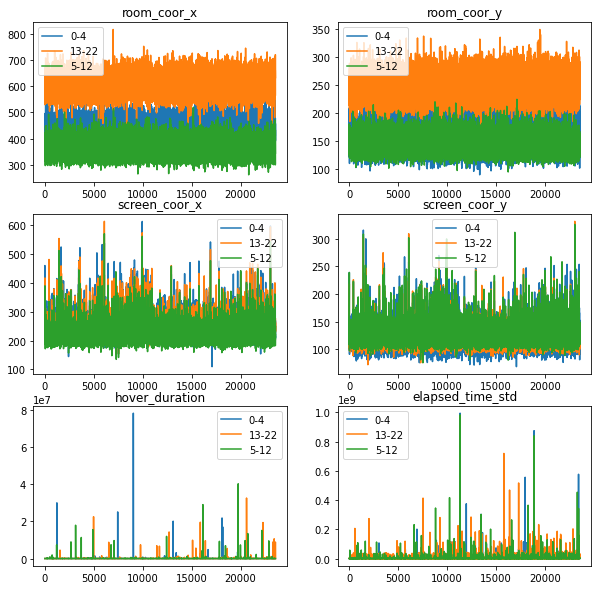

In [15]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))

for name, data in dataset_df.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['screen_coor_x_std'])+1), data['screen_coor_x_std'], label=name)
    axis[1, 1].plot(range(1, len(data['screen_coor_y_std'])+1), data['screen_coor_y_std'], label=name)
    axis[2, 0].plot(range(1, len(data['hover_duration'])+1), data['hover_duration_std'], label=name)
    axis[2, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)
    

axis[0, 0].set_title('room_coor_x')
axis[0, 1].set_title('room_coor_y')
axis[1, 0].set_title('screen_coor_x')
axis[1, 1].set_title('screen_coor_y')
axis[2, 0].set_title('hover_duration')
axis[2, 1].set_title('elapsed_time_std')

for i in range(3):
    axis[i, 0].legend()
    axis[i, 1].legend()

plt.show()

# Build Feature "event_duration"

The variable 'event_duration' represents the difference between 'elapsed_time' of two consecutive events. This can often indicate a user's reluctance or uncertainty in answering an unfamiliar question.

'Elapsed_time', on the other hand, often contains high values and is susceptible to considerable outliers. It lacks specific context to a single question, as it encompasses cumulative time from previous questions and other activities. These characteristics pose challenges for effective model training. In contrast, 'event_duration' typically contains smaller values than 'elapsed_time', and outlier influence can be mitigated by clipping excessively large values.

Given the vast size of the dataset, it's crucial to downsize the dataframe for computations before incorporating it back into the main data. This strategy is necessary to prevent overloading the processing kernel, which could otherwise lead to system crashes or other issues.


In [ ]:
dataset_df2 = pd.read_pickle("elapsed_time.pkl")

'''dataset_df2 = pd.read_csv(
    'train.csv',
    usecols = ['elapsed_time', 'session_id', 'level_group'])

dataset_df2=dataset_df2.groupby('session_id', as_index=False).apply(lambda x: x.sort_values('elapsed_time', ascending=True))
dataset_df2.reset_index(drop=True)




upper = 3.6e6 # 1 hour. events longer than 1 hour are outliers.

gps = []

# event_duration for every session of every group
# this code is slow but I think it is necessary because it simulates the test condition
for _, session in dataset_df2.groupby('session_id'):
    for _, gp in session.groupby('level_group'):
        event_duration = gp.elapsed_time.diff().fillna(0).clip(0, upper)
        gp['event_duration'] = event_duration
        gps.append(gp)
        
dataset_df2 = pd.concat(gps)
dataset_df2.to_pickle('elapsed_time.pkl')'''

# Split Data into Training and Testing

In [16]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

56547 examples in training, 14139 examples in testing.


# Model Selection
This project has previously tested the models below, GradientBoostedTreesModel was the most accurate. The full writeup is in the results section.

- RandomForestModel
- **GradientBoostedTreesModel**
- CartModel
- DistributedGradientBoostedTreesModel



A Gradient Boosted Decision Tree is a set of shallow decision trees trained sequentially. Each tree is trained to predict and then "correct" for the errors of the previously trained trees.

# About the Gradient Boosted Trees Model

### Decision Tree
A decision tree is a type of supervised learning algorithm that is mostly used in classification problems, although it works for regression tasks as well. It works for both categorical and continuous input and output variables. The name comes from the algorithm's approach to solving problems, which resembles a tree-like model of decisions.

A decision tree consists of:

- **Nodes:** Test for the value of a certain attribute.
- **Edges/branches:** Correspond to the outcome of a test and connect to the next node or leaf.
- **Leaf nodes:** Terminal nodes that predict the outcome (target variable).

The decision rules are generally in conjunction with each other and the main challenge for a decision tree lies in complex datasets, where these conjunctions of decision rules could lead to overfitting.

Decision Trees use Entropy, Information Gain, Gini Index, etc., to decide which feature is best for classification and the ordering of features in the tree. 

This algorithm is widely used because of its simplicity and the fact that it can be visually interpreted. It also requires relatively little data preprocessing, for example, data scaling.

### Gradient Boosted Tree Model
A Gradient Boosted Trees Model is a type of machine learning algorithm that falls under the category of ensemble learning methods. It's used for both regression and classification problems.

In essence, it constructs a model by iteratively adding a set of simple base models (also known as weak learners), typically decision trees, to create a strong overall model. The term 'gradient boosting' originates from the procedure of applying gradient descent algorithm to minimize the loss function, and 'boosting' refers to the ensemble learning technique of combining several weak learners to form a strong learner.

The process begins with a simple model that makes certain errors (or residuals) in predictions. Then, another decision tree is built to correct the previous errors. This process is repeated, each time building new trees that aim to correct the errors made by the sum of all the previous trees. The final model is the weighted sum of all the decision trees, where the weights are assigned depending on the effectiveness of each tree at reducing the error.

This approach helps in handling various types of data and can prevent overfitting to a certain extent. However, it can be computationally intensive and may require careful tuning of parameters.

# Training

A distinct model will be trained for each question to estimate whether a user will answer it correctly. With a total of 18 questions present in the dataset, this process will lead to the training of 18 individual models.

For the training loop, some data structures will be required to hold the trained models, as well as the predictions on the validation set and evaluation scores for the models.

These necessary structures will be generated using the corresponding code:

In [18]:
# Fetch the unique list of user sessions.
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users

prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store a model created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

Before proceeding with data training, it is crucial to comprehend the association between level_groups and questions.

In the context of this game, the first quiz checkpoint (questions 1 to 3) appears after the completion of levels 0 to 4. Therefore, for training questions 1 to 3, data from the level_group 0-4 will be employed. Following the same logic, data from the level_group 5-12 will be used to train questions 4 to 13, while data from the level_group 13-22 will be utilized for training questions 14 to 18.

A model will be trained for each question, with the resulting trained model being stored in the models dict.

In [19]:
# Iterate through questions 1 to 18 to train models for each question, evaluate
# the trained model and store the predicted values.
for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
        
    # Filter the rows in the datasets based on the selected level group. 
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]

    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model. 
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library 
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Gradient Boosted Trees Model with default settings. 
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.GradientBoostedTreesModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])

    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the 
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]         

    # Use the trained model to make predictions on the validation dataset and 
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()     

### q_no 1 grp 0-4


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
2023-06-22 14:16:39.975715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at http

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-06-22 14:16:45.155656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype int64 and shape [4713]
	 [[{{node Placeholder/_20}}]]


5/5 [==============================] - 0s 8ms/step
### q_no 2 grp 0-4


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:45.5566 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:45.5566 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step
### q_no 3 grp 0-4


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:47.0392 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:47.0392 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step
### q_no 4 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:48.4521 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:48.4521 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 7ms/step
### q_no 5 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:51.1399 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:51.1400 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

[INFO 23-06-22 14:16:52.5378 PDT kernel.cc:1242] Loading model from path /tmp/tmp7_fs7oti/model/ with prefix b616af3ac2fd442e
[INFO 23-06-22 14:16:52.5399 PDT kernel.cc:1074] Use fast generic engine
2023-06-22 14:16:52.543754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [18849]
	 [[{{node Placeholder/_8}}]]
2023-06-22 14:16:52.675031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [4713]
	 [[{{node Placeholder/_9}}]]


5/5 [==============================] - 0s 9ms/step
### q_no 6 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:52.9469 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:52.9470 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

[INFO 23-06-22 14:16:54.5580 PDT kernel.cc:1242] Loading model from path /tmp/tmpw6llu3l1/model/ with prefix 9106cc3c1f0c4ca9
[INFO 23-06-22 14:16:54.5606 PDT abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 23-06-22 14:16:54.5606 PDT kernel.cc:1074] Use fast generic engine
2023-06-22 14:16:54.564568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype double and shape [18849]
	 [[{{node Placeholder/_19}}]]
2023-06-22 14:16:54.691623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [4713]
	 [[{{node Placeholder/_8}}]]

5/5 [==============================] - 0s 7ms/step
### q_no 7 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:54.9364 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:54.9364 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 7ms/step
### q_no 8 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:56.6096 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:56.6096 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 11ms/step
### q_no 9 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:58.1350 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:58.1350 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 7ms/step
### q_no 10 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:16:59.9019 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:16:59.9019 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step
### q_no 11 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:17:01.9678 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:17:01.9678 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step
### q_no 12 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:17:03.7871 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:17:03.7871 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step
### q_no 13 grp 5-12


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:17:05.2605 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:17:05.2605 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step
### q_no 14 grp 13-22


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:17:07.2963 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:17:07.2964 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step
### q_no 15 grp 13-22


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:17:09.1254 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:17:09.1254 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step
### q_no 16 grp 13-22


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:17:11.0664 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:17:11.0664 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 7ms/step
### q_no 17 grp 13-22


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:17:12.5317 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:17:12.5317 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 8ms/step


2023-06-22 14:17:14.108187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype double and shape [4713]
	 [[{{node Placeholder/_9}}]]


### q_no 18 grp 13-22


/tmp/ipykernel_23630/3242602895.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["correct"] = train_labels["correct"]
/tmp/ipykernel_23630/3242602895.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df["correct"] = valid_labels["correct"]
[WARNING 23-06-22 14:17:14.3654 PDT gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-06-22 14:17:14.3654 PDT gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GO

5/5 [==============================] - 0s 7ms/step


In [ ]:

models = ['RandomForestModel', 'GradientBoostedTreesModel', 'CartModel', 'DistributedGradientBoostedTreesModel']
accuracies = [0.6832, 0.7558, 0.71, 0.7132]

# Inspect the Accuracy of the models.

Let's see the accuracy of each question's model. 


In [20]:
for name, value in evaluation_dict.items():
  print(f"question {name}: accuracy {value:.4f}")

print("\nAverage accuracy", sum(evaluation_dict.values())/18)

question 1: accuracy 0.7286
question 2: accuracy 0.9743
question 3: accuracy 0.9351
question 4: accuracy 0.7957
question 5: accuracy 0.6319
question 6: accuracy 0.7885
question 7: accuracy 0.7456
question 8: accuracy 0.6355
question 9: accuracy 0.7632
question 10: accuracy 0.6109
question 11: accuracy 0.6522
question 12: accuracy 0.8695
question 13: accuracy 0.7218
question 14: accuracy 0.7337
question 15: accuracy 0.6166
question 16: accuracy 0.7486
question 17: accuracy 0.7027
question 18: accuracy 0.9510

Average accuracy 0.7558526065614488


# Accuracies of different models

The writeup will be included in the results section.


In [26]:


df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
})

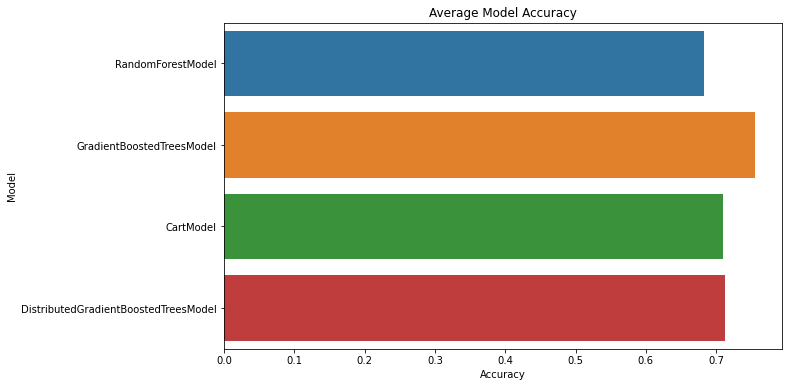

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=df)
plt.title('Average Model Accuracy')
plt.show()






## Feature Importance

Feature importance in machine learning signifies the impact of input features in predicting the target variable in a model. It aids in interpreting the model, performing feature selection, enhancing model performance, and improving domain understanding. Techniques to estimate feature importance include permutation importance, tree-based models' importance, and coefficients of linear or logistic regression models. Choosing a suitable method is essential, considering the dataset and model in use.

In [23]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("room_fqid_nunique" (1; #16), 9.0),
 ("level" (1; #7), 5.0),
 ("name_nunique" (1; #9), 5.0),
 ("text_fqid_nunique" (1; #21), 5.0),
 ("hover_duration_std" (1; #6), 4.0),
 ("page" (1; #10), 4.0),
 ("screen_coor_x_std" (1; #18), 4.0),
 ("elapsed_time" (1; #1), 2.0),
 ("page_std" (1; #11), 2.0),
 ("room_coor_x" (1; #12), 2.0),
 ("event_name_nunique" (1; #3), 1.0),
 ("room_coor_y_std" (1; #15), 1.0)]

We see that  ("elapsed_time" #1) has the highest value in feature importance. This makes sense as time spent on a question can determine a sense of uncertainty and wavering on the question.

# Threshold Hyperparameter Tuning

Given the considerable imbalance in the 'correct' column values, applying the standard threshold of 0.5 for classifying predictions into classes 0 or 1 could lead to subpar performance. To enhance performance in such situations, the F1 score is computed across a range of thresholds, aiming to identify the optimal threshold—the one yielding the highest F1 score. This threshold is subsequently utilized to convert predicted probabilities into class labels 0 or 1.

It's essential to mention that the F1 score serves as a superior metric compared to accuracy in assessing problems associated with class imbalance.

The threshold parameter, as encountered in the _F1 method, acts as a pre-established cut-off point that translates predicted probabilities into class predictions. Pertaining to binary classification, if the predicted probability surpasses the threshold, the data point gets classified as one class; otherwise, it is classified as the other class. Here, any prediction with a value exceeding 0.63 (the selected threshold) gets classified as '1', otherwise, it's categorized as '0'. The choice of threshold bears implications on the model's performance, thereby making the selection of an optimal threshold crucial.


In [24]:
# Create a dataframe of required size:
# (no: of users in validation set x no: of questions) initialized to zero values
# to store true values of the label `correct`. 
true_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[VALID_USER_LIST]
    true_df[i] = tmp.correct.values

max_score = 0; best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4,0.8,0.01):
    metric = tfa.metrics.F1Score(num_classes=2,average="macro",threshold=threshold)
    y_true = tf.one_hot(true_df.values.reshape((-1)), depth=2)
    y_pred = tf.one_hot((prediction_df.values.reshape((-1))>threshold).astype('int'), depth=2)
    metric.update_state(y_true, y_pred)
    f1_score = metric.result().numpy()
    if f1_score > max_score:
        max_score = f1_score
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)

Best threshold  0.6300000000000002 	F1 score  0.6738222


# Results

The model under investigation demonstrated a promising level of performance as indicated by various metrics procured from the stages of model training and evaluation.

The optimal threshold from our hyperparameter tuning for classifying predictions into classes was identified as 0.63, generating an F1 score of 0.6738222. The F1 score is the harmonic mean of precision and recall and is particularly useful in situations where the data may have an imbalance between positive and negative classes. An F1 score of 0.6738222 implies a balanced performance between precision (the model's ability to correctly identify positive results) and recall (the model's ability to find all the positive samples). This suggests that the model effectively predicts both positive and negative classes, validating the moderate success of the model.

In the process of model selection, three primary models were considered: RandomForestModel, GradientBoostedTreesModel, and CartModel. The model demonstrating the highest average accuracy of 0.7558 was the GradientBoostedTreesModel, proving it to be the most effective model among the options.

Inspecting the performance on individual questions, it was observed that the model's accuracy varied. The model demonstrated the lowest accuracy on question 10, which makes sense as that question had a 50:50 split between being answered incorrectly, implying a relatively higher level of uncertainty for this question. The .62 prediction accuracy is better than a random spread, so it seems there was at least SOME predictive power. The highest accuracy was achieved on question 2, which makes sense since over 95% had answered correctly, indicating question was easy and so the model can easily predict the result statistically.

Investigating the feature importance, the highest value was assigned to the feature "elapsed_time". This result aligns with the understanding that the time spent on a question could be an indicator of uncertainty and indecision, and hence, it can significantly impact the ability to correctly answer a question.

Moreover, the model exhibited a close convergence between training and validation losses, a good sign of the model learning effectively without overfitting. Overfitting is usually indicated by a significant discrepancy between these two losses, characterized by a much lower training loss. However, in the case of this model, the training and validation losses decreased in a closely aligned manner, highlighting the model's robust generalization capability.



# Conclusion

The goal of this project was to establish a predictive model for real-time assessment of student performance during game-based learning, leveraging one of the most extensive open datasets of game logs available. This venture served to expand the field of knowledge-tracing methodologies within game-based learning and provide insights for educational game developers to craft enhanced learning experiences.

The model demonstrated moderate success, evident from the F1 score of 0.6738222 and an average accuracy of 0.7558. Particularly notable was the role of the "elapsed_time" feature, affirming that the time spent on a question could significantly impact a student's ability to answer correctly. The model also showed a good balance between training and validation losses, indicating effective learning without overfitting.

However, some opportunities for improvement were identified. For example, while the model showed reasonable success overall, its accuracy varied across different questions. A closer look at each question, especially those with lower accuracy, could reveal specific aspects requiring further improvement or more tailored modeling approaches.

In addition, while feature engineering played a significant role in this study, it could be further optimized. Although adding more features degraded the performance in this case, a more careful selection of features could potentially yield better results. A more systematic approach to feature selection and extraction, possibly involving more sophisticated machine learning methods for feature selection, could improve the model's performance.

The biggest issue is that there is a clear ceiling in a model's predictive power. Even when the model doesn't overfit the data, the model fails to correctly identify. I feel the data lacks enough context to determine a student's hesitation and expertise in answering the question. For instance, HD and game music is a needless feature, and time_elapsed is insufficient to predict a students answer. 

The successful deployment of this model could have wide-ranging implications. It could empower educational game developers with insights to enhance the effectiveness of their games, and provide educators with robust analytical tools and dashboards to monitor and support student performance. This could lead to broader support and acceptance of game-based learning platforms in various educational contexts.

In conclusion, this project was a significant step towards applying data science and learning analytics principles to refine game-based learning. Despite some areas for improvement, the developed model's moderate success is a notable achievement, contributing valuable insights and paving the way for future advancements in this domain.




